# Part 1

In [446]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch

### Preprocessing The Dataset

In [447]:
#Read the set
df = pd.read_csv('dataset.csv')
df.head()
pass
df.dtypes

f1        object
f2        object
f3         int64
f4        object
f5        object
f6        object
f7        object
target     int64
dtype: object

In [221]:
#Deleting rows with alphabets
for i in df.columns:
    if df[i].dtype == object:
        df = df[~df[i].str.match(r'[^\d.]+')]
df.reset_index(drop=True, inplace=True)
# save the preprocessed data to a new CSV file
df.to_csv("preprocessed_data.csv", index=False)
pass

In [222]:
#Now we can check and confirm that all our columns are numerical 
preprocessed = pd.read_csv('preprocessed_data.csv')
preprocessed.dtypes

f1          int64
f2          int64
f3          int64
f4          int64
f5          int64
f6        float64
f7        float64
target      int64
dtype: object

In [223]:
#Scaling the dataset so lets get the target out
target = preprocessed.pop('target')
#Take the numerical cols
numerical_cols = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7']
preprocessed[numerical_cols] = torch.nn.functional.normalize(torch.tensor(preprocessed[numerical_cols].values), dim=0).numpy()
#Add back target
preprocessed['target'] = target
preprocessed.to_csv("scaled_data.csv", index=False)

In [224]:
df = pd.read_csv('scaled_data.csv')
df.dtypes

f1        float64
f2        float64
f3        float64
f4        float64
f5        float64
f6        float64
f7        float64
target      int64
dtype: object

In [225]:
from sklearn.model_selection import train_test_split
# Split the data into features (X) and target (y)
X = df.drop(columns=['target'])
y = df['target']

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the validation set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

# Print the shapes of the resulting arrays
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (608, 7), y_train shape: (608,)
X_val shape: (76, 7), y_val shape: (76,)
X_test shape: (76, 7), y_test shape: (76,)


In [226]:
#Transforming our dataframes to tensors
X_train = torch.Tensor(X_train.values)
X_val = torch.Tensor(X_val.values)
X_test = torch.Tensor(X_test.values)
y_train = torch.LongTensor(y_train.values)
y_val = torch.LongTensor(y_val.values)
y_test = torch.LongTensor(y_test.values)

### Implementing Our Neural Network

In [227]:
import torch
import torch.nn as nn
import torch.nn.init as init
#Defining our Neural Network according to given structure with 3 hidden layers, 128 nodes per layer and 7 input neurons for 7 features
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


# Create an instance of the neural network
model = NeuralNet()
print(model)

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=2, bias=True)
    (7): Sigmoid()
  )
)


In [230]:
from torch.utils.data import DataLoader, TensorDataset

# Define the batch size
batch_size = 32
#Dataloader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

# Create a DataLoader for the validation set
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

# Defining the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Training the model
#Lets define this as our fit function
def fit():
    num_epochs = 100
    for epoch in range(num_epochs):
        # Training
        train_loss = 0
        for (inputs, targets) in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training loss
            train_loss += loss.item()

        # Validation
        val_loss = 0
        with torch.no_grad():
            for (inputs, targets) in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()

        # Print epoch losses for every 10 epochs
        if (epoch+1)%10 == 0:
            print(f" For Epoch [{epoch+1}/{num_epochs}], training loss is: {train_loss/len(train_loader):.3f} and validation loss is: {val_loss/len(val_loader):.3f}")
fit()
#Now make predictions on test set
with torch.no_grad():
    outputs = model(X_test)
    predicted = torch.argmax(outputs, dim=1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f"Accuracy of the model on the test set is: {accuracy*100:.2f}%")
torch.save(model.state_dict(), 'rahuladi_gurukavy_assignment2_part1.pt')

 For Epoch [10/100], training loss is: 0.513 and validation loss is: 0.525
 For Epoch [20/100], training loss is: 0.510 and validation loss is: 0.520
 For Epoch [30/100], training loss is: 0.513 and validation loss is: 0.525
 For Epoch [40/100], training loss is: 0.515 and validation loss is: 0.525
 For Epoch [50/100], training loss is: 0.509 and validation loss is: 0.520
 For Epoch [60/100], training loss is: 0.512 and validation loss is: 0.544
 For Epoch [70/100], training loss is: 0.520 and validation loss is: 0.528
 For Epoch [80/100], training loss is: 0.509 and validation loss is: 0.529
 For Epoch [90/100], training loss is: 0.507 and validation loss is: 0.536
 For Epoch [100/100], training loss is: 0.506 and validation loss is: 0.509
Accuracy of the model on the test set is: 76.32%


### Visualization

In [231]:
#Visualization with confusion matrix
from sklearn.metrics import confusion_matrix

# Get the predictions on the validation set
with torch.no_grad():
    outputs = model(X_val)
    predicted = torch.argmax(outputs, dim=1)

# Compute the confusion matrix
cm = confusion_matrix(y_val, predicted)

# Print the confusion matrix
print('Confusion matrix:')
print(cm)

Confusion matrix:
[[44  8]
 [10 14]]


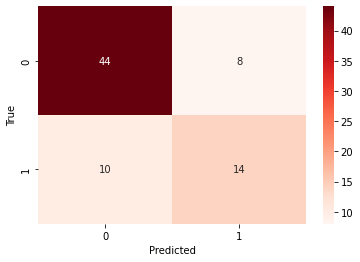

In [232]:
#Visualization with heat map shows false negative, true negative, false positive and true positive
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_val, predicted)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

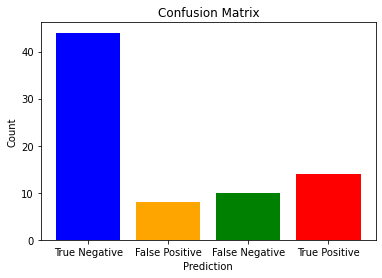

In [233]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_val, predicted)

# Extract values for true positives, false positives, false negatives, and true negatives
tn, fp, fn, tp = cm.ravel()

# Create a bar chart
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
values = [tn, fp, fn, tp]
colors = ['blue', 'orange', 'green', 'red']
plt.bar(labels, values, color=colors)

# Add labels and title
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.title('Confusion Matrix')

plt.show()

# Part 2

### Setup 1: Tuning Hyper Parameter-1 : Dropout with a dropout rate of 0.2

In [247]:
#Now we will be adding dropout layers
class NeuralNet(nn.Module):
    def __init__(self, dropout_rate):
        super(NeuralNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 2),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


# Create an instance of the neural network
model = NeuralNet(dropout_rate = 0.2)
print(model)

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=2, bias=True)
    (10): Sigmoid()
  )
)


In [248]:
from torch.utils.data import DataLoader, TensorDataset

# Define the batch size and create a DataLoader for the training set
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

# Create a DataLoader for the validation set
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Train the model
#Lets define this as our fit function
def fit():
    num_epochs = 100
    for epoch in range(num_epochs):
        # Training
        train_loss = 0
        for (inputs, targets) in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training loss
            train_loss += loss.item()

        # Validation
        val_loss = 0
        with torch.no_grad():
            for (inputs, targets) in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()

        # Print epoch losses for every 10 epochs
        if (epoch+1)%10 == 0:
            print(f" For Epoch [{epoch+1}/{num_epochs}], training loss is: {train_loss/len(train_loader):.3f} and validation loss is: {val_loss/len(val_loader):.3f}")
fit()
#Now make predictions on test set
with torch.no_grad():
    outputs = model(X_test)
    predicted = torch.argmax(outputs, dim=1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f"Accuracy of the model with dropout rate 0.2 is: {accuracy*100:.2f}%")
torch.save(model.state_dict(), 'rahuladi_gurukavy_assignment2_part2.pt')

 For Epoch [10/100], training loss is: 0.641 and validation loss is: 0.600
 For Epoch [20/100], training loss is: 0.610 and validation loss is: 0.547
 For Epoch [30/100], training loss is: 0.580 and validation loss is: 0.557
 For Epoch [40/100], training loss is: 0.564 and validation loss is: 0.547
 For Epoch [50/100], training loss is: 0.549 and validation loss is: 0.508
 For Epoch [60/100], training loss is: 0.544 and validation loss is: 0.496
 For Epoch [70/100], training loss is: 0.528 and validation loss is: 0.511
 For Epoch [80/100], training loss is: 0.523 and validation loss is: 0.471
 For Epoch [90/100], training loss is: 0.521 and validation loss is: 0.535
 For Epoch [100/100], training loss is: 0.515 and validation loss is: 0.495
Accuracy of the model with dropout rate 0.2 is: 78.95%


### Setup 2: Tuning Hyper Parameter-1 : Dropout with a dropout rate of 0.5

In [250]:
# Create an instance of the neural network
model = NeuralNet(dropout_rate = 0.5)
print(model)

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=128, out_features=2, bias=True)
    (10): Sigmoid()
  )
)


In [251]:
from torch.utils.data import DataLoader, TensorDataset

# Define the batch size and create a DataLoader for the training set
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

# Create a DataLoader for the validation set
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Train the model
#Lets define this as our fit function
def fit():
    num_epochs = 100
    for epoch in range(num_epochs):
        # Training
        train_loss = 0
        for (inputs, targets) in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training loss
            train_loss += loss.item()

        # Validation
        val_loss = 0
        with torch.no_grad():
            for (inputs, targets) in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()

        # Print epoch losses for every 10 epochs
        if (epoch+1)%10 == 0:
            print(f" For Epoch [{epoch+1}/{num_epochs}], training loss is: {train_loss/len(train_loader):.3f} and validation loss is: {val_loss/len(val_loader):.3f}")
fit()
#Now make predictions on test set
with torch.no_grad():
    outputs = model(X_test)
    predicted = torch.argmax(outputs, dim=1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f"Accuracy of the model with dropout rate 0.5 is: {accuracy*100:.2f}%")

 For Epoch [10/100], training loss is: 0.651 and validation loss is: 0.614
 For Epoch [20/100], training loss is: 0.644 and validation loss is: 0.601
 For Epoch [30/100], training loss is: 0.616 and validation loss is: 0.567
 For Epoch [40/100], training loss is: 0.592 and validation loss is: 0.536
 For Epoch [50/100], training loss is: 0.586 and validation loss is: 0.527
 For Epoch [60/100], training loss is: 0.575 and validation loss is: 0.541
 For Epoch [70/100], training loss is: 0.558 and validation loss is: 0.515
 For Epoch [80/100], training loss is: 0.551 and validation loss is: 0.542
 For Epoch [90/100], training loss is: 0.542 and validation loss is: 0.517
 For Epoch [100/100], training loss is: 0.541 and validation loss is: 0.547
Accuracy of the model with dropout rate 0.5 is: 78.95%


### Setup 3: Tuning Hyper Parameter-1 : Dropout with a dropout rate of 0.6

In [252]:
# Create an instance of the neural network
model = NeuralNet(dropout_rate = 0.6)
print(model)

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.6, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.6, inplace=False)
    (9): Linear(in_features=128, out_features=2, bias=True)
    (10): Sigmoid()
  )
)


In [253]:
from torch.utils.data import DataLoader, TensorDataset

# Define the batch size and create a DataLoader for the training set
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

# Create a DataLoader for the validation set
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Train the model
#Lets define this as our fit function
def fit():
    num_epochs = 100
    for epoch in range(num_epochs):
        # Training
        train_loss = 0
        for (inputs, targets) in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training loss
            train_loss += loss.item()

        # Validation
        val_loss = 0
        with torch.no_grad():
            for (inputs, targets) in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()

        # Print epoch losses for every 10 epochs
        if (epoch+1)%10 == 0:
            print(f" For Epoch [{epoch+1}/{num_epochs}], training loss is: {train_loss/len(train_loader):.3f} and validation loss is: {val_loss/len(val_loader):.3f}")
fit()
#Now make predictions on test set
with torch.no_grad():
    outputs = model(X_test)
    predicted = torch.argmax(outputs, dim=1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f"Accuracy of the model with dropout rate 0.6 is: {accuracy*100:.2f}%")

 For Epoch [10/100], training loss is: 0.647 and validation loss is: 0.588
 For Epoch [20/100], training loss is: 0.638 and validation loss is: 0.594
 For Epoch [30/100], training loss is: 0.626 and validation loss is: 0.567
 For Epoch [40/100], training loss is: 0.599 and validation loss is: 0.585
 For Epoch [50/100], training loss is: 0.599 and validation loss is: 0.558
 For Epoch [60/100], training loss is: 0.590 and validation loss is: 0.542
 For Epoch [70/100], training loss is: 0.561 and validation loss is: 0.531
 For Epoch [80/100], training loss is: 0.565 and validation loss is: 0.521
 For Epoch [90/100], training loss is: 0.550 and validation loss is: 0.530
 For Epoch [100/100], training loss is: 0.558 and validation loss is: 0.534
Accuracy of the model with dropout rate 0.6 is: 67.11%


### Setup 4: Truning Hyper Parameter-2 : Using RMSprop Optimizer lets fix dropout at 0.2 as it gave best result previously

In [254]:
# Create an instance of the neural network
model = NeuralNet(dropout_rate = 0.2)
print(model)

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=2, bias=True)
    (10): Sigmoid()
  )
)


In [255]:
from torch.utils.data import DataLoader, TensorDataset

# Define the batch size and create a DataLoader for the training set
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

# Create a DataLoader for the validation set
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)


# Train the model
#Lets define this as our fit function
def fit():
    num_epochs = 100
    for epoch in range(num_epochs):
        # Training
        train_loss = 0
        for (inputs, targets) in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training loss
            train_loss += loss.item()

        # Validation
        val_loss = 0
        with torch.no_grad():
            for (inputs, targets) in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()

        # Print epoch losses for every 10 epochs
        if (epoch+1)%10 == 0:
            print(f" For Epoch [{epoch+1}/{num_epochs}], training loss is: {train_loss/len(train_loader):.3f} and validation loss is: {val_loss/len(val_loader):.3f}")
fit()
#Now make predictions on test set
with torch.no_grad():
    outputs = model(X_test)
    predicted = torch.argmax(outputs, dim=1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f"Accuracy of the model with an RMSprop Optimizer is: {accuracy*100:.2f}%")

 For Epoch [10/100], training loss is: 0.643 and validation loss is: 0.590
 For Epoch [20/100], training loss is: 0.595 and validation loss is: 0.567
 For Epoch [30/100], training loss is: 0.586 and validation loss is: 0.557
 For Epoch [40/100], training loss is: 0.582 and validation loss is: 0.527
 For Epoch [50/100], training loss is: 0.562 and validation loss is: 0.531
 For Epoch [60/100], training loss is: 0.561 and validation loss is: 0.525
 For Epoch [70/100], training loss is: 0.537 and validation loss is: 0.508
 For Epoch [80/100], training loss is: 0.538 and validation loss is: 0.537
 For Epoch [90/100], training loss is: 0.537 and validation loss is: 0.540
 For Epoch [100/100], training loss is: 0.529 and validation loss is: 0.513
Accuracy of the model with an RMSprop Optimizer is: 73.68%


### Setup 5: Truning Hyper Parameter-2 : Using SGD Optimizer lets fix dropout at 0.2 as it yielded our best result previously

In [256]:
# Create an instance of the neural network
model = NeuralNet(dropout_rate = 0.2)
print(model)

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=2, bias=True)
    (10): Sigmoid()
  )
)


In [257]:
from torch.utils.data import DataLoader, TensorDataset

# Define the batch size and create a DataLoader for the training set
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

# Create a DataLoader for the validation set
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


# Train the model
#Lets define this as our fit function
def fit():
    num_epochs = 100
    for epoch in range(num_epochs):
        # Training
        train_loss = 0
        for (inputs, targets) in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training loss
            train_loss += loss.item()

        # Validation
        val_loss = 0
        with torch.no_grad():
            for (inputs, targets) in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()

        # Print epoch losses for every 10 epochs
        if (epoch+1)%10 == 0:
            print(f" For Epoch [{epoch+1}/{num_epochs}], training loss is: {train_loss/len(train_loader):.3f} and validation loss is: {val_loss/len(val_loader):.3f}")
fit()
#Now make predictions on test set
with torch.no_grad():
    outputs = model(X_test)
    predicted = torch.argmax(outputs, dim=1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f"Accuracy of the model with an SGD Optimizer is: {accuracy*100:.2f}%")

 For Epoch [10/100], training loss is: 0.689 and validation loss is: 0.687
 For Epoch [20/100], training loss is: 0.688 and validation loss is: 0.685
 For Epoch [30/100], training loss is: 0.687 and validation loss is: 0.684
 For Epoch [40/100], training loss is: 0.686 and validation loss is: 0.683
 For Epoch [50/100], training loss is: 0.685 and validation loss is: 0.682
 For Epoch [60/100], training loss is: 0.685 and validation loss is: 0.681
 For Epoch [70/100], training loss is: 0.684 and validation loss is: 0.680
 For Epoch [80/100], training loss is: 0.683 and validation loss is: 0.678
 For Epoch [90/100], training loss is: 0.683 and validation loss is: 0.678
 For Epoch [100/100], training loss is: 0.682 and validation loss is: 0.676
Accuracy of the model with an SGD Optimizer is: 63.16%


### Setup 6: Truning Hyper Parameter-2 : Using Adagrad Optimizer lets fix dropout at 0.2

In [258]:
# Create an instance of the neural network
model = NeuralNet(dropout_rate = 0.2)
print(model)

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=2, bias=True)
    (10): Sigmoid()
  )
)


In [259]:
from torch.utils.data import DataLoader, TensorDataset

# Define the batch size and create a DataLoader for the training set
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

# Create a DataLoader for the validation set
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)


# Train the model
#Lets define this as our fit function
def fit():
    num_epochs = 100
    for epoch in range(num_epochs):
        # Training
        train_loss = 0
        for (inputs, targets) in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training loss
            train_loss += loss.item()

        # Validation
        val_loss = 0
        with torch.no_grad():
            for (inputs, targets) in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()

        # Print epoch losses for every 10 epochs
        if (epoch+1)%10 == 0:
            print(f" For Epoch [{epoch+1}/{num_epochs}], training loss is: {train_loss/len(train_loader):.3f} and validation loss is: {val_loss/len(val_loader):.3f}")
fit()
#Now make predictions on test set
with torch.no_grad():
    outputs = model(X_test)
    predicted = torch.argmax(outputs, dim=1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f"Accuracy of the model with an Adagrad Optimizer is: {accuracy*100:.2f}%")

 For Epoch [10/100], training loss is: 0.649 and validation loss is: 0.610
 For Epoch [20/100], training loss is: 0.647 and validation loss is: 0.615
 For Epoch [30/100], training loss is: 0.649 and validation loss is: 0.606
 For Epoch [40/100], training loss is: 0.649 and validation loss is: 0.605
 For Epoch [50/100], training loss is: 0.648 and validation loss is: 0.606
 For Epoch [60/100], training loss is: 0.648 and validation loss is: 0.608
 For Epoch [70/100], training loss is: 0.647 and validation loss is: 0.601
 For Epoch [80/100], training loss is: 0.646 and validation loss is: 0.606
 For Epoch [90/100], training loss is: 0.646 and validation loss is: 0.609
 For Epoch [100/100], training loss is: 0.646 and validation loss is: 0.609
Accuracy of the model with an Adagrad Optimizer is: 63.16%


### Setup 7: Tuning Hyper Parameter-3 : Activation Function as Softmax lets keep dropout at 0.2 and fix Adam Optimizer as best results were obtained this way

In [263]:
#Now we will be adding dropout layers
class NeuralNet(nn.Module):
    def __init__(self, dropout_rate):
        super(NeuralNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


# Create an instance of the neural network
model = NeuralNet(dropout_rate = 0.2)
print(model)

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=2, bias=True)
    (10): Softmax(dim=1)
  )
)


In [267]:
from torch.utils.data import DataLoader, TensorDataset

# Define the batch size and create a DataLoader for the training set
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

# Create a DataLoader for the validation set
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Train the model
#Lets define this as our fit function
def fit():
    num_epochs = 100
    for epoch in range(num_epochs):
        # Training
        train_loss = 0
        for (inputs, targets) in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training loss
            train_loss += loss.item()

        # Validation
        val_loss = 0
        with torch.no_grad():
            for (inputs, targets) in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()

        # Print epoch losses for every 10 epochs
        if (epoch+1)%10 == 0:
            print(f" For Epoch [{epoch+1}/{num_epochs}], training loss is: {train_loss/len(train_loader):.3f} and validation loss is: {val_loss/len(val_loader):.3f}")
fit()
#Now make predictions on test set
with torch.no_grad():
    outputs = model(X_test)
    predicted = torch.argmax(outputs, dim=1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f"Accuracy of the model on the test set is: {accuracy*100:.2f}%")

 For Epoch [10/100], training loss is: 0.511 and validation loss is: 0.513
 For Epoch [20/100], training loss is: 0.513 and validation loss is: 0.518
 For Epoch [30/100], training loss is: 0.504 and validation loss is: 0.513
 For Epoch [40/100], training loss is: 0.517 and validation loss is: 0.527
 For Epoch [50/100], training loss is: 0.518 and validation loss is: 0.515
 For Epoch [60/100], training loss is: 0.514 and validation loss is: 0.523
 For Epoch [70/100], training loss is: 0.512 and validation loss is: 0.538
 For Epoch [80/100], training loss is: 0.505 and validation loss is: 0.496
 For Epoch [90/100], training loss is: 0.512 and validation loss is: 0.515
 For Epoch [100/100], training loss is: 0.509 and validation loss is: 0.511
Accuracy of the model on the test set is: 77.63%


### Setup 8: Tuning Hyper Parameter-3 : Activation Function as Tanh lets keep dropout at 0.2 and fix Adam Optimizer from part 1

In [268]:
#Tuning Hyper Parameter-1 : Dropout
#First using dropout rate of 0.2
#Now we will be adding dropout layers
class NeuralNet(nn.Module):
    def __init__(self, dropout_rate):
        super(NeuralNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 2),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


# Create an instance of the neural network
model = NeuralNet(dropout_rate = 0.2)
print(model)

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=2, bias=True)
    (10): Tanh()
  )
)


In [269]:
from torch.utils.data import DataLoader, TensorDataset

# Define the batch size and create a DataLoader for the training set
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

# Create a DataLoader for the validation set
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Train the model
#Lets define this as our fit function
def fit():
    num_epochs = 100
    for epoch in range(num_epochs):
        # Training
        train_loss = 0
        for (inputs, targets) in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training loss
            train_loss += loss.item()

        # Validation
        val_loss = 0
        with torch.no_grad():
            for (inputs, targets) in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()

        # Print epoch losses for every 10 epochs
        if (epoch+1)%10 == 0:
            print(f" For Epoch [{epoch+1}/{num_epochs}], training loss is: {train_loss/len(train_loader):.3f} and validation loss is: {val_loss/len(val_loader):.3f}")
fit()
#Now make predictions on test set
with torch.no_grad():
    outputs = model(X_test)
    predicted = torch.argmax(outputs, dim=1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f"Accuracy of the model on the test set is: {accuracy*100:.2f}%")

 For Epoch [10/100], training loss is: 0.628 and validation loss is: 0.575
 For Epoch [20/100], training loss is: 0.574 and validation loss is: 0.492
 For Epoch [30/100], training loss is: 0.545 and validation loss is: 0.491
 For Epoch [40/100], training loss is: 0.532 and validation loss is: 0.465
 For Epoch [50/100], training loss is: 0.509 and validation loss is: 0.443
 For Epoch [60/100], training loss is: 0.489 and validation loss is: 0.501
 For Epoch [70/100], training loss is: 0.496 and validation loss is: 0.444
 For Epoch [80/100], training loss is: 0.503 and validation loss is: 0.429
 For Epoch [90/100], training loss is: 0.490 and validation loss is: 0.484
 For Epoch [100/100], training loss is: 0.484 and validation loss is: 0.462
Accuracy of the model on the test set is: 73.68%


### Setup 9: Tuning Hyper Parameter-3 : Activation Function as Relu lets keep dropout at 0.2 and fix Adam Optimizer from part 1

In [270]:
#Tuning Hyper Parameter-1 : Dropout
#First using dropout rate of 0.2
#Now we will be adding dropout layers
class NeuralNet(nn.Module):
    def __init__(self, dropout_rate):
        super(NeuralNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 2),
            nn.ReLU()
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


# Create an instance of the neural network
model = NeuralNet(dropout_rate = 0.2)
print(model)

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=2, bias=True)
    (10): ReLU()
  )
)


In [272]:
from torch.utils.data import DataLoader, TensorDataset

# Define the batch size and create a DataLoader for the training set
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

# Create a DataLoader for the validation set
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Train the model
#Lets define this as our fit function
def fit():
    num_epochs = 100
    for epoch in range(num_epochs):
        # Training
        train_loss = 0
        for (inputs, targets) in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training loss
            train_loss += loss.item()

        # Validation
        val_loss = 0
        with torch.no_grad():
            for (inputs, targets) in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()

        # Print epoch losses for every 10 epochs
        if (epoch+1)%10 == 0:
            print(f" For Epoch [{epoch+1}/{num_epochs}], training loss is: {train_loss/len(train_loader):.3f} and validation loss is: {val_loss/len(val_loader):.3f}")
fit()
#Now make predictions on test set
with torch.no_grad():
    outputs = model(X_test)
    predicted = torch.argmax(outputs, dim=1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f"Accuracy of the model on the test set is: {accuracy*100:.2f}%")

 For Epoch [10/100], training loss is: 0.460 and validation loss is: 0.483
 For Epoch [20/100], training loss is: 0.480 and validation loss is: 0.483
 For Epoch [30/100], training loss is: 0.453 and validation loss is: 0.444
 For Epoch [40/100], training loss is: 0.465 and validation loss is: 0.445
 For Epoch [50/100], training loss is: 0.466 and validation loss is: 0.465
 For Epoch [60/100], training loss is: 0.462 and validation loss is: 0.476
 For Epoch [70/100], training loss is: 0.462 and validation loss is: 0.469
 For Epoch [80/100], training loss is: 0.455 and validation loss is: 0.452
 For Epoch [90/100], training loss is: 0.459 and validation loss is: 0.461
 For Epoch [100/100], training loss is: 0.458 and validation loss is: 0.459
Accuracy of the model on the test set is: 75.00%


### Base Model - Setup 1 Optimizer - Adam, Dropout - 0.2, Activation Function - Sigmoid, Accuracy 78.95

### Applying Weight Decay

In [275]:
#Now we will be adding dropout layers
class NeuralNet(nn.Module):
    def __init__(self, dropout_rate):
        super(NeuralNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 2),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


# Create an instance of the neural network
model = NeuralNet(dropout_rate = 0.2)
print(model)

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=2, bias=True)
    (10): Sigmoid()
  )
)


In [283]:
# Create an instance of the neural network
model = NeuralNet(dropout_rate=0.2)

# Define the batch size and create a DataLoader for the training set
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

# Create a DataLoader for the validation set
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001) # set weight decay here

# Train the model
def fit():
    num_epochs = 100
    for epoch in range(num_epochs):
        # Training
        train_loss = 0
        for (inputs, targets) in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training loss
            train_loss += loss.item()

        # Validation
        val_loss = 0
        with torch.no_grad():
            for (inputs, targets) in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()

        # Print epoch losses for every 10 epochs
        if (epoch+1)%10 == 0:
            print(f" For Epoch [{epoch+1}/{num_epochs}], training loss is: {train_loss/len(train_loader):.3f} and validation loss is: {val_loss/len(val_loader):.3f}")

fit()
#Now make predictions on test set
with torch.no_grad():
    outputs = model(X_test)
    predicted = torch.argmax(outputs, dim=1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f"Accuracy of the model is: {accuracy*100:.2f}%")

 For Epoch [10/100], training loss is: 0.645 and validation loss is: 0.603
 For Epoch [20/100], training loss is: 0.600 and validation loss is: 0.553
 For Epoch [30/100], training loss is: 0.569 and validation loss is: 0.528
 For Epoch [40/100], training loss is: 0.554 and validation loss is: 0.523
 For Epoch [50/100], training loss is: 0.548 and validation loss is: 0.497
 For Epoch [60/100], training loss is: 0.544 and validation loss is: 0.521
 For Epoch [70/100], training loss is: 0.529 and validation loss is: 0.494
 For Epoch [80/100], training loss is: 0.535 and validation loss is: 0.494
 For Epoch [90/100], training loss is: 0.531 and validation loss is: 0.492
 For Epoch [100/100], training loss is: 0.524 and validation loss is: 0.504
Accuracy of the model is: 72.37%


### Applying Batch Normalization To Our Model

In [292]:
class NeuralNet(nn.Module):
    def __init__(self, dropout_rate):
        super(NeuralNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 2),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
# Create an instance of the neural network
model = NeuralNet(dropout_rate = 0.2)
print(model)

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=128, out_features=2, bias=True)
    (13): Sigmoid()
  )
)


In [297]:
from torch.utils.data import DataLoader, TensorDataset

# Define the batch size and create a DataLoader for the training set
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

# Create a DataLoader for the validation set
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Train the model
#Lets define this as our fit function
def fit():
    num_epochs = 100
    for epoch in range(num_epochs):
        # Training
        train_loss = 0
        for (inputs, targets) in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training loss
            train_loss += loss.item()

        # Validation
        val_loss = 0
        with torch.no_grad():
            for (inputs, targets) in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()

        # Print epoch losses for every 10 epochs
        if (epoch+1)%10 == 0:
            print(f" For Epoch [{epoch+1}/{num_epochs}], training loss is: {train_loss/len(train_loader):.3f} and validation loss is: {val_loss/len(val_loader):.3f}")
fit()
#Now make predictions on test set
with torch.no_grad():
    outputs = model(X_test)
    predicted = torch.argmax(outputs, dim=1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f"Accuracy of the model is: {accuracy*100:.2f}%")

 For Epoch [10/100], training loss is: 0.423 and validation loss is: 0.635
 For Epoch [20/100], training loss is: 0.420 and validation loss is: 0.660
 For Epoch [30/100], training loss is: 0.439 and validation loss is: 0.588
 For Epoch [40/100], training loss is: 0.428 and validation loss is: 0.598
 For Epoch [50/100], training loss is: 0.431 and validation loss is: 0.629
 For Epoch [60/100], training loss is: 0.425 and validation loss is: 0.614
 For Epoch [70/100], training loss is: 0.422 and validation loss is: 0.606
 For Epoch [80/100], training loss is: 0.416 and validation loss is: 0.617
 For Epoch [90/100], training loss is: 0.422 and validation loss is: 0.554
 For Epoch [100/100], training loss is: 0.433 and validation loss is: 0.658
Accuracy of the model is: 71.05%


### Apply Learn Rate Scheduler

In [378]:
#Now we will be adding dropout layers
class NeuralNet(nn.Module):
    def __init__(self, dropout_rate):
        super(NeuralNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 2),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


# Create an instance of the neural network
model = NeuralNet(dropout_rate = 0.2)
print(model)

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=2, bias=True)
    (10): Sigmoid()
  )
)


In [334]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Train the model
def fit():
    num_epochs = 100
    for epoch in range(num_epochs):
        # Training
        train_loss = 0
        for (inputs, targets) in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training loss
            train_loss += loss.item()

        # Validation
        val_loss = 0
        with torch.no_grad():
            for (inputs, targets) in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()

        # Step the learning rate scheduler
        lr_scheduler.step(val_loss)

        # Print epoch losses for every 10 epochs
        if (epoch+1)%10 == 0:
            print(f" For Epoch [{epoch+1}/{num_epochs}], training loss is: {train_loss/len(train_loader):.3f} and validation loss is: {val_loss/len(val_loader):.3f}")
fit()
#Now make predictions on test set
with torch.no_grad():
    outputs = model(X_test)
    predicted = torch.argmax(outputs, dim=1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f"Accuracy of the model is: {accuracy*100:.2f}%")

 For Epoch [10/100], training loss is: 0.521 and validation loss is: 0.498
Epoch 00014: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00020: reducing learning rate of group 0 to 1.0000e-05.
 For Epoch [20/100], training loss is: 0.516 and validation loss is: 0.530
Epoch 00026: reducing learning rate of group 0 to 1.0000e-06.
 For Epoch [30/100], training loss is: 0.510 and validation loss is: 0.531
Epoch 00032: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00038: reducing learning rate of group 0 to 1.0000e-08.
 For Epoch [40/100], training loss is: 0.519 and validation loss is: 0.497
 For Epoch [50/100], training loss is: 0.513 and validation loss is: 0.468
 For Epoch [60/100], training loss is: 0.516 and validation loss is: 0.493
 For Epoch [70/100], training loss is: 0.513 and validation loss is: 0.494
 For Epoch [80/100], training loss is: 0.512 and validation loss is: 0.508
 For Epoch [90/100], training loss is: 0.519 and validation loss is: 0.502
 For Epoch [100

### Applying Gradient Clipping

In [340]:
print(model)

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=2, bias=True)
    (10): Sigmoid()
  )
)


In [379]:
import torch.nn.utils as torch_utils
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the maximum gradient norm value
max_grad_norm = 1.0

# Train the model
def fit():
    num_epochs = 100
    for epoch in range(num_epochs):
        pass
        # Training
        train_loss = 0
        for (inputs, targets) in train_loader:
            pass
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()

            # Clip gradients to avoid exploding gradients
            torch_utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()

            # Calculate training loss
            train_loss += loss.item()

        # Validation
        val_loss = 0
        pass
        with torch.no_grad():
            for (inputs, targets) in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()

        # Print epoch losses for every 10 epochs
        if (epoch+1)%10 == 0:
            pass
            print(f" For Epoch [{epoch+1}/{num_epochs}], training loss is: {train_loss/len(train_loader):.3f} and validation loss is: {val_loss/len(val_loader):.3f}")

fit()
#Now make predictions on test set
with torch.no_grad():
    outputs = model(X_test)
    predicted = torch.argmax(outputs, dim=1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f"Accuracy of the model is: {accuracy*100:.2f}%")

 For Epoch [10/100], training loss is: 0.645 and validation loss is: 0.604
 For Epoch [20/100], training loss is: 0.603 and validation loss is: 0.555
 For Epoch [30/100], training loss is: 0.581 and validation loss is: 0.522
 For Epoch [40/100], training loss is: 0.569 and validation loss is: 0.507
 For Epoch [50/100], training loss is: 0.556 and validation loss is: 0.496
 For Epoch [60/100], training loss is: 0.543 and validation loss is: 0.527
 For Epoch [70/100], training loss is: 0.530 and validation loss is: 0.505
 For Epoch [80/100], training loss is: 0.528 and validation loss is: 0.508
 For Epoch [90/100], training loss is: 0.525 and validation loss is: 0.505
 For Epoch [100/100], training loss is: 0.528 and validation loss is: 0.495
Accuracy of the model is: 75.00%


## Applying K-fold

In [382]:
print(model)

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=2, bias=True)
    (10): Sigmoid()
  )
)


In [426]:
# Define a function to train and evaluate the model using K-Fold Cross Validation
def train_and_evaluate(X, y, k=5, dropout_rate=0.2, num_epochs=100, lr=0.001):
    kfs = KFold(n_splits=k)
    accuracies = []
    fold_num = 1
    
    for train_idx, val_idx in kfs.split(X):
        # Spliting  the data into training and validation sets
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        # Create a DataLoader for the training sets
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

        # Create a DataLoader for the validationsets
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

        # Initialzing the model and the loss function
        model = NeuralNet(dropout_rate)
        loss_fn = nn.CrossEntropyLoss()

        # Initialize the optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Train the model
        for epoch in range(num_epochs):
            # Training
            pass
            train_loss = 0
            for (inputs, targets) in train_loader:
                # Forward pass
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Calculate training loss
                train_loss += loss.item()

            # Validation
            val_loss = 0
            pass
            with torch.no_grad():
            
                for (inputs, targets) in val_loader:
                    outputs = model(inputs)
                    pass
                    for i in val_loader:
                        pass
                    loss = loss_fn(outputs, targets)
                    for j in val_loader:
                        pass
                    val_loss += loss.item()
                    

# Evaluate the model on the test set
with torch.no_grad():
    outputs = model(X_test)
    pass
    predicted = torch.argmax(outputs, dim=1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f"Accuracy of the model is: {accuracy*100:.2f}%")

Accuracy of the model is: 78.95%


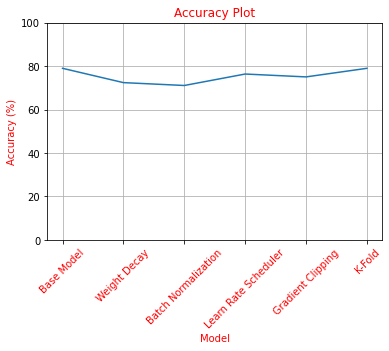

In [454]:
import matplotlib.pyplot as plt

# Data
accuracies = [78.95, 72.37, 71.05, 76.32, 75.00, 78.95]

# Define x-axis labels
x_labels = ['Base Model', 'Weight Decay', 'Batch Normalization', 'Learn Rate Scheduler', 'Gradient Clipping', 'K-Fold']

# Plot
plt.plot(accuracies)

# Customize plot
plt.title("Accuracy Plot",color = 'red')
plt.xlabel("Model",color = 'red')
plt.ylabel("Accuracy (%)",color = 'red')
plt.xticks(range(len(accuracies)), x_labels, rotation=45, color='red')  # Set x-axis labels color to red
plt.ylim([0, 100])
plt.grid(True)

# Show plot
plt.show()